In [78]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [79]:
import numpy as np
import pandas as pd

In [80]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [81]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [82]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [83]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [84]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Find the most recent date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [89]:
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(first_date)

2016-08-23


In [90]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > first_date)

In [91]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_datadf = pd.DataFrame(precip_data)
print(precip_datadf)

#setting the index to the date column 
precip_datadf.set_index('date').head()

#sorting by date
precip_datadf.sort_values(by=['date'])

            date  prcp
0     2016-08-24  0.08
1     2016-08-25  0.08
2     2016-08-26  0.00
3     2016-08-27  0.00
4     2016-08-28  0.01
...          ...   ...
2218  2017-08-19  0.09
2219  2017-08-20   NaN
2220  2017-08-21  0.56
2221  2017-08-22  0.50
2222  2017-08-23  0.45

[2223 rows x 2 columns]


,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


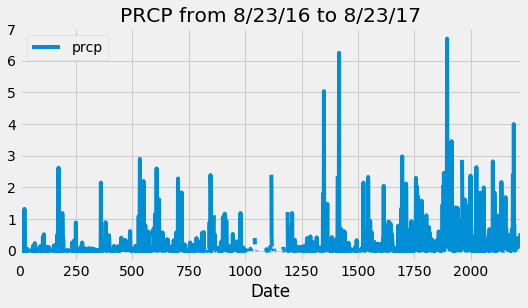

In [92]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_datadf.plot(figsize=(8,4))
ax.set_title("PRCP from 8/23/16 to 8/23/17")
plt.xlabel("Date")
plt.show()

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_datadf.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [94]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station)
print(active)
active2=active[0][0]    

SELECT measurement.station AS measurement_station, count(measurement.station) AS count 
FROM measurement GROUP BY measurement.station


In [113]:
# List the stations and the counts in descending order.
active_df = pd.DataFrame(active)
print(active_df)

       station  count
0  USC00511918   1979
1  USC00513117   2709
2  USC00514830   2202
3  USC00516128   2612
4  USC00517948   1372
5  USC00518838    511
6  USC00519281   2772
7  USC00519397   2724
8  USC00519523   2669


In [114]:
active_df.sort_values(by='count', ascending=False)

,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [141]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = active[0][0]
most_activetemp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_activetemp[0][0]} High: {most_activetemp[0][1]} Average: {round(most_activetemp[0][2], 1)}")

Most Active Station Temperatures
Low: 53.0 High: 87.0 Average: 71.6


In [172]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

In [173]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(first_date < Measurement.date).\
filter(Measurement.date > last_date)

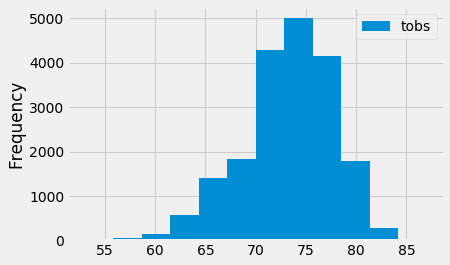

In [174]:
plt.hist(temp_df['tobs'],12)
plt.legend(["tobs"])
plt.ylabel("Frequency")
plt.show()

In [191]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [198]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2016-08-23', '2017-08-23')

In [199]:
trip_df = pd.DataFrame(data=trip, columns=["tmin", "tavg", "tmax"])
print(trip_df)

   tmin       tavg  tmax
0  58.0  74.590583  87.0


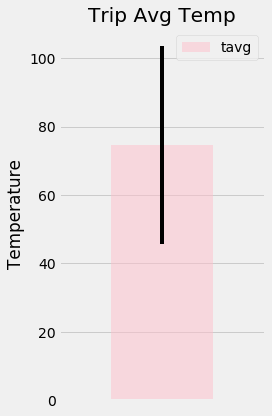

In [202]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='pink', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


In [190]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(first_date, last_date):
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= first_date).filter(Measurement.date <= last_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2016-08-23','2017-08-23'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
